# d3PG

In [315]:
using Cropbox
using CSV
using DataFrames
using Dates
using TimeZones

In [225]:
weather = CSV.read("weather.csv", DataFrame);

`Parameters` contains all the parameters for the model. Convenient for configuration.

In [474]:
@system Parameters begin
    # Stand initialisation and site factor data
    iAge ~ preserve(parameter) # Initial age
    iWF ~ preserve(parameter, u"kg/ha") # Initial foliage mass
    iWR ~ preserve(parameter, u"kg/ha") # Initial root mass
    iWS ~ preserve(parameter, u"kg/ha") # Initial stem mass
    iStemNo ~ preserve(parameter, u"ha^-1") # Initial stem count
    iASW ~ preserve(parameter, u"mm") # Initial available soil water
    lat ~ preserve(parameter) # Latitude
    FR ~ preserve(parameter) # Fertility rating
    CO2 ~ preserve(parameter) # Atmospheric CO2
    maxASW ~ preserve(parameter, u"mm") # Maximum available soil water
    minASW ~ preserve(parameter, u"mm") # Minimum available soi water
    soilClass ~ preserve(parameter) # Soil class
    irrigation ~ preserve(parameter, u"mm/d")
    poolFractn ~ preserve(parameter)
    
    # Biomass partitioning and turnover
    ## Allometric relationships & partitioning
    pFS2 ~ preserve(parameter) # Foliage:stem partitioning ratio at D=2cm
    pFS20 ~ preserve(parameter) # Foliage:stem partitioning ratio at D=20cm
    aWs ~ preserve(parameter) # Stem mass vs. diameter constant
    nWs ~ preserve(parameter) # Stem mass vs. diameter exponent
    pRx ~ preserve(parameter) # Maximum fraction of NPP to roots
    pRn ~ preserve(parameter) # Minimum fraction of NPP to roots
    ## Litterfall & root turnover
    gammaF1 ~ preserve(parameter) # Maximum litterfall rate
    gammaF0 ~ preserve(parameter) # Literfall rate at t = 0
    tgammaF ~ preserve(parameter) # Age at which litterfall rate has median value
    gammaR  ~ preserve(parameter) # Average monthly root turnover rate
    
    # NPP & conductance modifiers
    ## Temperature modifer
    tMin ~ preserve(parameter) # Minimum temperature for growth
    tOpt ~ preserve(parameter) # Optimal temperature for growth
    tMax ~ preserve(parameter) # Maximum temperature for growth
    ## Frost modifier
    kF ~ preserve(parameter) # Days of production lost per frost day
    ## Soil water modifier
    SWconst0 ~ preserve(parameter) # Moisture ratio deficit for fTheta = 0.5
    SWpower0 ~ preserve(parameter) # Power of moisture ratio deficit
    ## Atmospheric CO2 modifier
    fCalpha700 ~ preserve(parameter) # Assimilation enhancement factor at 700ppm
    fCg700 ~ preserve(parameter) # Canopy conductance enhancement factor at 700ppm
    ## Fertility effects
    m0 ~ preserve(parameter) # Value of 'm' when FR = 0
    fN0 ~ preserve(parameter) # Value of 'fNutr' when FR = 0
    fNn ~ preserve(parameter) # Power of (1-FR) in 'fNutr'
    ## Age modifier
    maxAge ~ preserve(parameter) # Maximum stand age used in age modifier 
    nAge ~ preserve(parameter) # Power of relative age in function for fAge
    rAge ~ preserve(parameter) # Relative age to give fAge = 0.5
    
    # Stem mortality & self-thinning
    gammaN1 ~ preserve(parameter) # Mortality rate for large t
    gammaN0 ~ preserve(parameter) # Seedling mortality rate (t=0)
    tgammaN ~ preserve(parameter) # Age at which mortality rate has median value
    ngammaN ~ preserve(parameter) # Shape of mortality response
    wSx1000 ~ preserve(parameter, u"kg") # Max. stem mass per tree at 1000 trees/hectare
    thinPower ~ preserve(parameter) # Power in self-thinning rule
    mF ~ preserve(parameter) # Fraction mean single-tree foliage biomass lost per dead tree
    mR ~ preserve(parameter) # Fraction mean single-tree root biomass lost per dead tree
    mS ~ preserve(parameter) # # Fraction mean single-tree stem biomass lost per dead tree
    
    # Canopy structure and processes
    ## Specific leaf area
    SLA0 ~ preserve(parameter, u"m^2/kg") # Specific leaf area at age 0
    SLA1 ~ preserve(parameter, u"m^2/kg") # Specfic leaf area for mature leaves
    tSLA ~ preserve(parameter) # Age at which specific leaf area = (SLA0 + SLA1)/2
    ## Light intercetion
    k ~ preserve(parameter) # Extinction coefficient for absorption of PAR by canopy
    fullCanAge ~ preserve(parameter) # Age at canopy cover
    maxIntcptn ~ preserve(parameter) # Maximum propotion of rainfall evaporated from canopy
    LAImaxIntcptn ~ preserve(parameter) # LAI for maximum rainfall interception
    ## Production and respiration
    alphaCx ~ preserve(parameter) # Canopy quantum efficiency
    y ~ preserve(parameter) # Ratio NPP/GPP
    ## Conductance
    minCond ~ preserve(parameter, u"m/s") # Minimum canopy conductance
    maxCond ~ preserve(parameter, u"m/s") # Maximum canopy conductance
    LAIgcx ~ preserve(parameter) # LAI for maximum canopy conductance
    coeffCond ~ preserve(parameter, u"mbar^-1") # Defines stomatal response to VPD
    BLcond ~ preserve(parameter, u"m/s") # Canopy boundary layer conductance
    
    # Wood and stand properties
    ## Branch and bark fraction
    fracBB0 ~ preserve(parameter) # Branch and bark fraction at age 0
    fracBB1 ~ preserve(parameter) # Branch and bark fraction for mature stands
    tBB ~ preserve(parameter) # Age at which frac BB = (fracBB0 + fracBB1) / 2
    ## Basic density
    rho0 ~ preserve(parameter, u"kg/m^3") # Minimum basic density (for young trees)
    rho1 ~ preserve(parameter, u"kg/m^3") # Maximum basic density (for older trees)
    tRho ~ preserve(parameter) # Age at which rho = (rhoMin + rhoMax) / 2
    ## Stem height
    aH ~ preserve(parameter) # Constant in the stem height relationship
    nHB ~ preserve(parameter) # Power of DBH in the stem height relationship
    nHN ~ preserve(parameter) # Power of stocking in the stem height relationship
    ## Stem volume
    aV ~ preserve(parameter) # Constant in the stem volume relationship
    nVB ~ preserve(parameter) # Power of DBH in the stem volume relationship
    nVN ~ preserve(parameter) # Power of stocking in the stem volume relationship
    
    # Conversion factors
    Qa ~ preserve(parameter, u"W/m^2") # Intercept of net vs. solar radiation relationship
    Qb ~ preserve(parameter) # Slope of net vs. solar radiation relationship
    gDM_mol ~ preserve(parameter, u"g/mol") # Molecular weight of dry matter
    molPAR_MJ ~ preserve(parameter, u"mol/MJ") # Conversion of solar radiation to PAR
    
    # Derived parameters
    iW(iWS, iWF, iWR) => iWS + iWF + iWR ~ preserve(u"kg/ha") # Initial total drymass
    SWconst(soilClass, SWconst0) => ((soilClass > 0) ? (0.8 - 0.1 * soilClass) : (SWconst0)) ~ preserve
    SWpower(soilClass, SWpower0) => ((soilClass > 0) ? (11 - 2 * soilClass) : (SWpower0)) ~ preserve
    pfsPower(pFS2, pFS20) => log(pFS20 / pFS2) / log(20 / 2) ~ preserve
    pfsConst(pFS2, pfsPower) => pFS2 / 2 ^ pfsPower ~ preserve
    fCalphax(fCalpha700) => fCalpha700 / (2 - fCalpha700) ~ preserve
    fCg0(fCg700) => fCg700 / (2 * fCg700 - 1) ~ preserve
end

Parameters

In [481]:
c = @config(
    :Clock => :step => 1u"d",
    :Calendar => (;
        :init => ZonedDateTime(1990, 6, 1, tz"Australia/Hobart"),
    ),
    :Climate => :data => weather,
    :Parameters => (;
        :iAge => 730,
        :iWF => 4000,
        :iWR => 5000,
        :iWS => 4000,
        :iStemNo => 1430,
        :iASW => 190,
        :lat => -43.3,
        :FR => 1,
        :CO2 => 350,
        :maxASW => 190,
        :minASW => 190,
        :soilClass => 3,
        :irrigation => 0,
        :maxAge => 50,
        :nAge => 4,
        :rAge => 0.95,
        :fullCanAge => 3,
        :k => 0.5,
        :gammaR => 0.015,
        :SWconst0 => 0.7,
        :SWpower0 => 9,
        :fCalpha700 => 1.4,
        :fCg700 => 0.7,
        :maxIntcptn => 0.15,
        :LAImaxIntcptn => 0,
        :minCond => 0,
        :maxCond => 0.02,
        :LAIgcx => 3.33,
        :BLcond => 0.2,
        :coeffCond => 0.05,
        :y => 0.47,
        :tMax => 40,
        :tMin => 8.5,
        :tOpt => 16,
        :kF => 0,
        :pFS2 => 1,
        :pFS20 => 0.15,
        :aWs => 0.095,
        :nWs => 2.4,
        :pRx => 0.8,
        :pRn => 0.25,
        :m0 => 0,
        :fN0 => 1,
        :fNn => 0,
        :alphaCx => 0.06,
        :poolFractn => 0,
        :gammaN1 => 0.03,
        :gammaN0 => 0,
        :tgammaN => 3,
        :ngammaN => 1,
        :wSx1000 => 300,
        :thinPower => 3 / 2,
        :mF => 0,
        :mR => 0.2,
        :mS => 0.2,    
        :gammaF1 => 0.027,
        :gammaF0 => 0.001,
        :tgammaF => 12,
        :SLA0 => 11,
        :SLA1 => 4,
        :tSLA => 2.5,
        :fracBB0 => 0.75,
        :fracBB1 => 0.15,
        :tBB => 2,
        :rho0 => 450,
        :rho1 => 450,
        :tRho => 4,
        :aH => 0.6,
        :nHB => 1.2,
        :nHN => 0,
        :aV => 0,
        :nVB => 0,
        :nVN => 0,
        :Qa => -90,
        :Qb => 0.8,
        :gDM_mol => 24,
        :molPAR_MJ => 2.3
    )
);

In [461]:
c2 = @config(
    :Clock => :step => 1u"d",
    :Calendar => (;
        :init => ZonedDateTime(1990, 6, 1, tz"Australia/Hobart"),
    ),
    :Climate => :data => weather,
    :Parameters => (;
        :iAge => 730,
        :iWF => 4000,
        :iWR => 5000,
        :iWS => 4000,
        :iStemNo => 1430,
        :iASW => 190,
        :lat => -43.3,
        :FR => 1,
        :CO2 => 350,
        :maxASW => 190,
        :minASW => 0,
        :soilClass => 3,
        :irrigation => 0.1,
        :maxAge => 50,
        :nAge => 4,
        :rAge => 0.95,
        :fullCanAge => 3,
        :k => 0.5,
        :gammaR => 0.015,
        :SWconst0 => 0.7,
        :SWpower0 => 9,
        :fCalpha700 => 1.4,
        :fCg700 => 0.7,
        :maxIntcptn => 0.15,
        :LAImaxIntcptn => 0,
        :minCond => 0,
        :maxCond => 0.02,
        :LAIgcx => 3.33,
        :BLcond => 0.2,
        :coeffCond => 0.05,
        :y => 0.47,
        :tMax => 40,
        :tMin => 8.5,
        :tOpt => 16,
        :kF => 0,
        :pFS2 => 1,
        :pFS20 => 0.15,
        :aWs => 0.095,
        :nWs => 2.4,
        :pRx => 0.8,
        :pRn => 0.25,
        :m0 => 0,
        :fN0 => 1,
        :fNn => 0,
        :alphaCx => 0.06,
        :poolFractn => 0.1,
        :gammaN1 => 0,
        :gammaN0 => 0,
        :tgammaN => 0,
        :ngammaN => 1,
        :wSx1000 => 300,
        :thinPower => 3 / 2,
        :mF => 0,
        :mR => 0.2,
        :mS => 0.2,    
        :gammaF1 => 0.027,
        :gammaF0 => 0.001,
        :tgammaF => 12,
        :SLA0 => 11,
        :SLA1 => 4,
        :tSLA => 2.5,
        :fracBB0 => 0.75,
        :fracBB1 => 0.15,
        :tBB => 2,
        :rho0 => 450,
        :rho1 => 450,
        :tRho => 4,
        :aH => 0.6,
        :nHB => 1.2,
        :nHN => 0,
        :aV => 0,
        :nVB => 0,
        :nVN => 0,
        :Qa => -90,
        :Qb => 0.8,
        :gDM_mol => 24,
        :molPAR_MJ => 2.3
    )
);

In [335]:
@system Climate begin
    # Data
    data ~ provide(parameter, index=:Date, init=calendar.date) # Dataframe with data
    tHigh ~ drive(from=data, by=:Tmax) # Highest temperature of the day
    tLow ~ drive(from=data, by=:Tmin) # Lowest temperature of the day
    rain ~ drive(from=data, by=:Rain, u"mm/d") # Rain
    rad ~ drive(from=data, by=:Rad, u"MJ/m^2/d") # Solar radiation
    
    # Calculate daylength fraction using latitude and day of year
    sLat(lat) => sin(pi * lat / 180) ~ preserve 
    cLat(lat) => cos(pi * lat / 180) ~ preserve
    sinDec(calendar) => 0.4 * sin(0.0172 * (dayofyear(calendar.date') - 80)) ~ track
    cosH0(sLat, cLat, sinDec) => -sinDec * sLat / (cLat * sqrt(1 - sinDec ^ 2)) ~ track
    daylength(cosH0) => acos(cosH0) / pi ~ track
    
    # Average(midrange) temperature
    tAvg(tHigh, tLow) => (tHigh + tLow) / 2 ~ track
    
    # VPD calculation using temperature
    VPD(tLow, tHigh) => begin
        VPDx = 6.1078 * exp(17.269 * tHigh / (237.3 + tHigh))
        VPDn = 6.1078 * exp(17.269 * tLow / (237.3 + tLow))
        (VPDx - VPDn) / 2
    end ~ track(u"mbar")
end

Climate

In [355]:
@system CanopyProduction begin
    ## LUE modifier (temperature)
    flagTemp(tAvg, tMin, tMax) => (tAvg >= tMin && tAvg <= tMax) ~ flag
    fTemperature(tAvg, tMin, tMax, tOpt) => begin
        ((tAvg - tMin) / (tOpt - tMin)) * ((tMax - tAvg) / (tMax - tOpt)) ^ ((tMax - tOpt) / (tOpt - tMin))
    end ~ track(when=flagTemp)

    # LUE modifier (VPD)
    fVPD(VPD, coeffCond) => begin
        exp(-coeffCond * VPD)
    end ~ track

    # LUE modifier (available soil water)
    fSW(ASW, maxASW, SWconst, SWpower) => begin
        1 / (1 + ((1 - (ASW / maxASW)) / SWconst) ^ SWpower)
    end ~ track

    # LUE modifier (soil nutrition)
    flagSN(fNn) => fNn != 0 ~ flag
    fSN(FR, fNn, fN0) => begin
        if fNn == 0
            1  
        else
            1 - (1 - fN0) * (1 - FR) ^ fNn
        end
    end ~ track

    # LUE modifier (frost)
    flagFrost(tLow) => (tLow < 0) ~ flag
    fFrost(kF) => 1 - kF ~ track(when=flagFrost, init=1)
    
    # LUE modifier (ambient CO2)
    fCalpha(fCalphax, CO2) => fCalphax * CO2 / (350 * (fCalphax - 1) + CO2) ~ track

    # LUE modifier (age)
    flagAge(nAge) => nAge != 0 ~ flag
    fAge(standAge, maxAge, rAge, nAge) => (1 / (1 + (standAge / maxAge / rAge) ^ nAge)) ~ track(when=flagAge, init=1)

    # LUE modifier (VPD, ASW, age)
    fPhysiology(fVPD, fSW, fAge) => begin
        min(fVPD, fSW) * fAge
    end ~ track

    # Canopy cover and light interception
    canCover(standAge, fullCanAge) => standAge / fullCanAge ~ track(max=1)
    lightIntcptn(k, LAI, canCover) => 1 - (exp(-k * LAI / canCover)) ~ track
    
    # Canopy quantum efficiency after modifiers
    alphaC(alphaCx, fSN, fTemperature, fFrost, fCalpha, fPhysiology) => begin
        alphaCx * fSN * fTemperature * fFrost * fCalpha * fPhysiology
    end ~ track

    # Canopy quantum efficiency in g/MJ
    epsilon(gDM_mol, molPAR_MJ, alphaC) => gDM_mol * molPAR_MJ * alphaC ~ track(u"g/MJ")
    
    # Intercepted radiation
    radInt(rad, lightIntcptn, canCover) => rad * lightIntcptn * canCover ~ track(u"MJ/m^2/d")
    
    # Gross primary production
    GPP(epsilon, radInt, transpScaleFactor) => epsilon * radInt * transpScaleFactor ~ track(u"kg/ha/d")
    
    # Net primary production
    NPP(GPP, y) => GPP * y ~ track(u"kg/ha/d")
end

CanopyProduction

In [441]:
@system WaterBalance begin
    # ASW and MaxASW and pool in mm/d
    ASWday(ASW) => ASW / u"d" ~ track(u"mm/d")
    maxASWday(maxASW) => maxASW / u"d" ~ track(u"mm/d")
    poolDay(pool) => pool / u"d" ~ track(u"mm/d")
    
    # Conductance modifier (ambient CO2)
    fCg(fCg0, CO2) => fCg0 / (1 + (fCg0 - 1) * CO2 / 350) ~ track 
    
    # Canopy conductance
    cond(LAI, LAIgcx, minCond, maxCond) => minCond + (maxCond - minCond) * LAI / LAIgcx ~ track(u"m/s", max=maxCond)
    canCond(cond, fPhysiology, fCg) => cond * fPhysiology * fCg ~ track(u"m/s")

    # Constants in the Penman-Monteith formula (Landsberg & Gower, 1997)
    e20 => 2.2 ~ preserve # Rate of change of saturated VP with T at 20C
    rhoAir => 1.2 ~ preserve(u"kg/m^3") # Density of air
    lambda => 2460000 ~ preserve(u"J/kg") # Latent heat of vaporization of H2O
    VPDconv => 0.000622 ~ preserve(u"mbar^-1") # Convert VPD to saturation deficit
    
    # Radiation in W/m^2
    netRad(Qa, Qb, rad, daylength) => begin
        Qa + Qb * (rad / (daylength))
    end ~ track(u"W/m^2")
        
    # defTerm (?)
    defTerm(rhoAir, lambda, VPDconv, VPD, BLcond) => begin
        rhoAir * lambda * (VPDconv * VPD) * BLcond
    end ~ track(u"W/m^2")
        
    # div (?)
    div(e20, BLcond, canCond) => begin
        canCond * (1 + e20) + BLcond
    end ~ track(u"m/s")
     
    # eTransp (?)
    eTransp(canCond, e20, netRad, defTerm, div) => begin
        canCond * (e20 * netRad + defTerm) / div 
    end ~ track(u"J/s/m^2")
    
    # Canopy transpiration
    canTransp(eTransp, lambda, daylength) => begin
        eTransp / lambda * daylength * 1u"cm^3/g" # Water density
    end ~ track(u"mm/d")
            
    # Intercepted rainfall ratio
    intcptn(maxIntcptn, LAI, LAImaxIntcptn) => begin
        (LAImaxIntcptn == 0) ? (maxIntcptn) : (maxIntcptn * min(1, LAI / LAImaxIntcptn))
    end ~ track

    # Intercepted rainfall
    rainIntcptn(intcptn, rain) => intcptn * rain ~ track(u"mm/d")
      
    # Canopy evapotranspiration
    evapTransp(canTransp, rainIntcptn) => begin
        canTransp + rainIntcptn
    end ~ track(u"mm/d", max=ASWday)
    
    excessSW(ASWday, maxASWday, evapTransp, irrigation, rain) => begin
        ASWday + rain - evapTransp + irrigation - maxASWday
    end ~ track(u"mm/d", min=0u"mm/d")
    
    lossPool(ASWday, maxASWday, evapTransp, irrigation, rain, poolDay) => begin
        maxASWday - (ASWday - evapTransp + irrigation + rain + poolDay)
    end ~ track(u"mm/d", min=0u"mm/d", max=poolDay)
    
    gainPool(excessSW, poolFractn) => begin
        poolFractn * excessSW
    end ~ track(u"mm/d", min=0u"mm/d")
    
    # Daily change in water pool
    dPool(gainPool, lossPool) => gainPool - lossPool ~ track(u"mm/d")
    
    # Daily runoff
    dRunoff(poolFractn, excessSW) => begin
        (1 - poolFractn) * excessSW
    end ~ track(u"mm/d")
    
    # Daily change in available soil water
    dASW(dPool, evapTransp, irrigation, rain) => begin
         -dPool - evapTransp + irrigation + rain
    end ~ track(u"mm/d")
    
    # GPP modifier in case not enough moisture in soil
    transpScaleFactor(evapTransp, canTransp, rainIntcptn) => begin
        evapTransp / (canTransp + rainIntcptn)
    end ~ track
end

WaterBalance

In [408]:
@system BiomassPartition begin
    # Calculating partiioning coefficients
    m(m0, FR) => m0 + (1 - m0) * FR ~ preserve
    pFS(pfsConst, nounit(avDBH), pfsPower) => pfsConst * (avDBH ^ pfsPower) ~ track # foliage and stem partition
    pR(pRx, pRn, fPhysiology, m) => pRx * pRn / (pRn + ( pRx - pRn) * fPhysiology * m) ~ track # root partition
    pS(pR, pFS) => (1 - pR) / (1 + pFS) ~ track # stem partition
    pF(pR, pS) => 1 - pR - pS ~ track # foliage partition

    # Calculate biomass increment
    growthFoliage(NPP, pF) => NPP * pF ~ track(u"kg/ha/d") # foliage
    growthRoot(NPP, pR) => NPP * pR ~ track(u"kg/ha/d") # root
    growthStem(NPP, pS) => NPP * pS ~ track(u"kg/ha/d") # stem
    
    # Monthly litterfall rate
    gammaF(gammaF1, gammaF0, standAge, tgammaF) => begin
        if tgammaF * gammaF1 == 0
            gammaF1
        else
            kgammaF = 12 * log(1 + gammaF1 / gammaF0) / tgammaF
            gammaF1 * gammaF0 / (gammaF0 + (gammaF1 - gammaF0) * exp(-kgammaF * standAge))
        end
    end ~ track
    
    # Daily litterfall rate
    gammaFday(calendar, gammaF) => begin
        (1 - (1 - gammaF)^(1 / daysinmonth(calendar.date'))) / u"d"
    end ~ track(u"d^-1")
    
    # Daily root turnover rate
    gammaRday(calendar, gammaR) => begin
        (1 - (1 - gammaR)^(1 / daysinmonth(calendar.date'))) / u"d"
    end ~ track(u"d^-1")

    litterfall(gammaFday, WF) => gammaFday * WF ~ track(u"kg/ha/d")
    rootTurnover(gammaRday, WR) => gammaRday * WR ~ track(u"kg/ha/d")
    
    #WF1(WF, incrWF, lossWF) => WF + incrWF - lossWF ~ track(u"kg/ha")
    #WR1(WR, incrWR, lossWR) => WR + incrWR - lossWR ~ track(u"kg/ha")
    #WS1(WS, incrWS) => WS + incrWS ~ track(u"kg/ha")
    #TotalW1(WF1, WR1, WS1) => WF1 + WR1 + WS1 ~ track
end

BiomassPartition

In [494]:
@system Mortality begin
    # Thinning
    
    # Defoliation
    
    # Mortality rate (yearly)
    gammaN(standAge, gammaN0, gammaN1, tgammaN, ngammaN) => begin
        gammaN1 + (gammaN0 - gammaN1) * exp(-log(2) * (standAge / tgammaN) ^ ngammaN)
    end ~ track
    
    # Mortality rate (daily)
    gammaNday(calendar, gammaN) => begin
        (1 - (1 - gammaN)^(1 / daysinyear(calendar.date'))) / u"d"
    end ~ track(u"d^-1")
    
    # Mortality flag
    flagMortal(gammaNday) => gammaNday > 0u"d^-1" ~ flag
    
    # Dead trees per hectare per day
    mortality(gammaNday, stemNo) => gammaNday * stemNo ~ track(u"ha^-1/d", when=flagMortal)
    
    deathFoliage(WF, mF, mortality, stemNo) => begin
        mF * mortality * (WF / stemNo)
    end ~ track(u"kg/ha/d", when=flagMortal)
    
    deathRoot(WR, mR, mortality, stemNo) => begin
        mR * mortality * (WR / stemNo)
    end ~ track(u"kg/ha/d", when=flagMortal)
    
    deathStem(WS, mS, mortality, stemNo) => begin
        mS * mortality * (WS / stemNo)
    end ~ track(u"kg/ha/d", when=flagMortal)
            
    #= Ignore for now
    stemNo1(gammaN, stemNo, delStems) => begin
        if gammaN > 0
            stemNo - delStems
        else
            stemNo
        end
    end ~ track(u"ha^-1")
    =#
    #=
    # Calculate self-thinning mortality
    wSmax(wSx1000, stemNo1, thinPower) => begin
        wSx1000 * (1000u"ha^-1" / stemNo1) ^ thinPower 
    end ~ track(u"kg")
    
    avStemMass1(WS2, stemNo1) => WS2 / stemNo1 ~ track(u"kg")
    
    accuracy => 1 / 1000 ~ preserve(parameter)
    n(stemNo1) => stemNo1 / 1000u"ha^-1" ~ track
    x1(mS, WS2, stemNo1) => mS * WS2 / stemNo1 ~ track(u"kg")
    i => 0 ~ preserve
    
    delStems1(accuracy, n, x1, i, stemNo1, mS, wSx1000, thinPower, WS2) => begin
        #=
        while true
            i = i + 1
            x2 = wSx1000 * (n ^ (1 - thinPower))
            fN = x2 - x1 * n - (1 - mS) * (WS2*u"ha")
            dfN = (1 - thinPower) * x2 / n - x1
            dN = -1 * fN / dfN
            n = n + dN
            if (abs(dN) <= accuracy) || (i >= 5)
                break
            end
        end
        floor(stemNo1 - 1000u"ha^-1" * n)
        =#
    end ~ track(u"ha^-1")
    
    WF3(wSmax, avStemMass1, WF2, mF, delStems1, stemNo1) => begin
        if wSmax < avStemMass1
            WF2 - mF * delStems1 * (WF2 / stemNo1)
        else
            WF2
        end
    end ~ track(u"kg/ha")
    
    WR3(wSmax, avStemMass1, WR2, mR, delStems1, stemNo1) => begin
        if wSmax < avStemMass1
            WR2 - mR * delStems1 * (WR2 / stemNo1)
        else
            WR2
        end
    end ~ track(u"kg/ha")
    
    WS3(wSmax, avStemMass1, WS2, mS, delStems1, stemNo1) => begin
        if wSmax < avStemMass1
            WS2 - mS * delStems1 * (WS2 / stemNo1)
        else
            WS2
        end
    end ~ track(u"kg/ha")
    =#
    #=
    dWF(WF, WF3) => (WF3 - WF) * u"d^-1" ~ track(u"kg/ha/d")
    
    dWR(WR, WR3) => (WR3 - WR) * u"d^-1" ~ track(u"kg/ha/d")
    
    dWS(WS, WS3) => (WS3 - WS) * u"d^-1" ~ track(u"kg/ha/d")
            
    stemNo2(wSmax, avStemMass1, stemNo1, delStems1) => begin
        if wSmax < avStemMass1
            stemNo1 - delStems1
        else
            stemNo1
        end
    end ~ track(u"ha^-1")
    
    dStemNo(stemNo, stemNo2) => (stemNo2 - stemNo) * u"d^-1" ~ track(u"ha^-1/d")
    
    # selfThin(delStems1) ~ accumulate(u"ha^-1")
    =#
    
    dStemNo(mortality) => -mortality ~ track(u"ha^-1/d")
end

Mortality

In [495]:
@system d3PG(Parameters, Climate, CanopyProduction, WaterBalance, BiomassPartition, Mortality, Controller) begin
    # Calendar variable to reference date
    calendar(context) ~ ::Calendar
    
    # Stand age in days and years
    standAgeDay => 1 ~ accumulate::Int64(init=iAge, timeunit=u"d")
    standAge(calendar, standAgeDay) => standAgeDay / daysinyear(calendar.date') ~ track # stand age (years)
    
    # Soil water
    ASW(dASW) ~ accumulate(u"mm", init=iASW, min=minASW, max=maxASW)
    pool(dPool) ~ accumulate(u"mm")
    runoff(dRunoff) ~ accumulate(u"mm")
    
    # Daily drymass of foliage, root, and stem per hectare
    dWF(growthFoliage, litterfall, deathFoliage) => growthFoliage - litterfall - deathFoliage ~ track(u"kg/ha/d")
    dWR(growthRoot, rootTurnover, deathRoot) => growthRoot - rootTurnover - deathRoot ~ track(u"kg/ha/d")
    dWS(growthStem, deathStem) => growthStem - deathStem ~ track(u"kg/ha/d")
    dW(dWF, dWR, dWS) => dWF + dWR + dWS ~ track(u"kg/ha/d")
    
    # Accumulated drymass of foliage, root, and stem per hectare
    WF(dWF) ~ accumulate(u"kg/ha", init=iWF) # foliage drymass
    WR(dWR) ~ accumulate(u"kg/ha", init=iWR) # root drymass
    WS(dWS) ~ accumulate(u"kg/ha", init=iWS) # stem drymass
    W(dW) ~ accumulate(u"kg/ha", init=iW) # total drymass

    # Number of trees per hectare
    stemNo(dStemNo) ~ accumulate(init=iStemNo, u"ha^-1")
    
    # Specific leaf area based on stand age (years)
    SLA(standAge, SLA0, SLA1, tSLA) => begin
        SLA1 + (SLA0 - SLA1) * exp(-log(2) * (standAge / tSLA) ^ 2)
    end ~ track(u"m^2/kg")
    
    # Branch and bark fraction based on stand age (years)
    fracBB(standAge, fracBB0, fracBB1, tBB) => begin
        fracBB1 + (fracBB0 - fracBB1) * exp(-log(2) * (standAge / tBB))
    end ~ track
    
    # Density based on stand age (years)
    density(standAge, rho0, rho1, tRho) => begin
        rho1 + (rho0 - rho1) * exp(-log(2) * (standAge / tRho))
    end ~ track(u"kg/m^3")
    
    # Average tree mass
    avStemMass(WS, stemNo) => WS / stemNo ~ track(u"kg")
    
    # Average diameter at breast height
    avDBH(nounit(avStemMass), aWs, nWs) => begin
        (avStemMass / aWs) ^ (1 / nWs)
    end ~ track(u"cm")
    
    # Base area
    basArea(avDBH, stemNo) => begin
        (((avDBH / 2) ^ 2) * pi) * stemNo
    end ~ track(u"m^2/ha") # base area
    
    # Height
    height(aH, nounit(avDBH), nHB, nHN, stemNo) => begin
        aH * avDBH ^ nHB * stemNo ^ nHN
    end ~ track
    
    # Leaf Area Index
    LAI(WF, SLA) => WF * SLA ~ track
    
    # Stand volume per hectare
    standVol(WS, aV, avDBH, nVB, nVN, fracBB, stemNo, density) => begin
        if aV > 0
            aV * avDBH ^ nVB * stemNo ^ nVN
        else
            WS * (1 - fracBB) / density
        end
    end ~ track(u"m^3/ha")
    
    # Mean volume increment per hectare
    MAI(standVol, standAge) => ((standAge > 0) ? (standVol / standAge) : 0) ~ track(u"m^3/ha")
end

d3PG

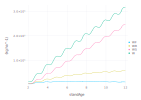

In [496]:
visualize(d3PG, :standAge, [:WF, :WR, :WS, :W]; config=c, stop=3660, kind=:line)

In [504]:
simulate(d3PG; config=c, stop=2562, index=:standAge, target=[
        :ASW,
        :pool,
        :runoff,
        :rain,
        :canTransp,
        :rainIntcptn,
        :evapTransp,
        :excessSW,
        :lossPool,
        :gainPool,
        :dPool,
        :dRunoff,
        :dASW,
        ])

Progress: 100%[===========================] Time: 0:00:04 ( 1.69 ms/it)


Row,standAge,ASW,pool,runoff,rain,canTransp,rainIntcptn,evapTransp,excessSW,lossPool,gainPool,dPool,dRunoff,dASW
,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,2.0,190.0 mm,0.0 mm,0.0 mm,1.5 mm d^-1,1.02481 mm d^-1,0.225 mm d^-1,1.24981 mm d^-1,0.250188 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.250188 mm d^-1,0.250188 mm d^-1
2,2.00274,190.0 mm,0.0 mm,0.250188 mm,1.5 mm d^-1,1.02291 mm d^-1,0.225 mm d^-1,1.24791 mm d^-1,0.252091 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.252091 mm d^-1,0.252091 mm d^-1
3,2.00548,190.0 mm,0.0 mm,0.50228 mm,1.5 mm d^-1,1.0211 mm d^-1,0.225 mm d^-1,1.2461 mm d^-1,0.253904 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.253904 mm d^-1,0.253904 mm d^-1
4,2.00822,190.0 mm,0.0 mm,0.756184 mm,1.5 mm d^-1,1.01938 mm d^-1,0.225 mm d^-1,1.24438 mm d^-1,0.255625 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.255625 mm d^-1,0.255625 mm d^-1
5,2.01096,190.0 mm,0.0 mm,1.01181 mm,1.5 mm d^-1,1.01775 mm d^-1,0.225 mm d^-1,1.24275 mm d^-1,0.257252 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.257252 mm d^-1,0.257252 mm d^-1
6,2.0137,190.0 mm,0.0 mm,1.26906 mm,1.5 mm d^-1,1.01622 mm d^-1,0.225 mm d^-1,1.24122 mm d^-1,0.258783 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.258783 mm d^-1,0.258783 mm d^-1
7,2.01644,190.0 mm,0.0 mm,1.52784 mm,1.5 mm d^-1,1.01478 mm d^-1,0.225 mm d^-1,1.23978 mm d^-1,0.260218 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.260218 mm d^-1,0.260218 mm d^-1
8,2.01918,190.0 mm,0.0 mm,1.78806 mm,1.5 mm d^-1,1.01344 mm d^-1,0.225 mm d^-1,1.23844 mm d^-1,0.261555 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.261555 mm d^-1,0.261555 mm d^-1
9,2.02192,190.0 mm,0.0 mm,2.04962 mm,1.5 mm d^-1,1.01221 mm d^-1,0.225 mm d^-1,1.23721 mm d^-1,0.262793 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.0 mm d^-1,0.262793 mm d^-1,0.262793 mm d^-1


In [505]:
simulate(d3PG; config=c, stop=2562, index=:standAge, target=[
        :standAge,
        :standAgeDay,
        :basArea,
        :WF,
        :WR,
        :WS,
        :standVol, 
        :LAI,
        :MAI,
        :avDBH,
        :height,
        :ASW,
        :mortality,
    ]
)

Progress: 100%[===========================] Time: 0:00:10 ( 4.22 ms/it)


Row,standAge,standAgeDay,basArea,WF,WR,WS,standVol,LAI,MAI,avDBH,height,ASW,mortality
,Float64,Int64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Float64,Quantity…,Quantity…
1,2.0,730,1.88188 m^2 ha^-1,4000.0 kg ha^-1,5000.0 kg ha^-1,4000.0 kg ha^-1,4.88889 m^3 ha^-1,3.3968,2.44444 m^3 ha^-1,4.09339 cm,3.25575,190.0 mm,0.0437349 ha^-1 d^-1
2,2.00274,731,1.88186 m^2 ha^-1,3996.47 kg ha^-1,4997.45 kg ha^-1,3999.98 kg ha^-1,4.89139 m^3 ha^-1,3.39162,2.44235 m^3 ha^-1,4.09344 cm,3.25579,190.0 mm,0.0437809 ha^-1 d^-1
3,2.00548,732,1.88185 m^2 ha^-1,3992.94 kg ha^-1,4994.9 kg ha^-1,3999.95 kg ha^-1,4.89389 m^3 ha^-1,3.38644,2.44026 m^3 ha^-1,4.09348 cm,3.25583,190.0 mm,0.0438269 ha^-1 d^-1
4,2.00822,733,1.88183 m^2 ha^-1,3989.42 kg ha^-1,4992.36 kg ha^-1,3999.93 kg ha^-1,4.89638 m^3 ha^-1,3.38127,2.43817 m^3 ha^-1,4.09352 cm,3.25587,190.0 mm,0.0438729 ha^-1 d^-1
5,2.01096,734,1.88181 m^2 ha^-1,3985.9 kg ha^-1,4989.81 kg ha^-1,3999.9 kg ha^-1,4.89888 m^3 ha^-1,3.37611,2.43609 m^3 ha^-1,4.09356 cm,3.25591,190.0 mm,0.0439188 ha^-1 d^-1
6,2.0137,735,1.88179 m^2 ha^-1,3982.37 kg ha^-1,4987.27 kg ha^-1,3999.88 kg ha^-1,4.90137 m^3 ha^-1,3.37095,2.43401 m^3 ha^-1,4.0936 cm,3.25595,190.0 mm,0.0439647 ha^-1 d^-1
7,2.01644,736,1.88177 m^2 ha^-1,3978.86 kg ha^-1,4984.73 kg ha^-1,3999.85 kg ha^-1,4.90386 m^3 ha^-1,3.3658,2.43194 m^3 ha^-1,4.09364 cm,3.25599,190.0 mm,0.0440106 ha^-1 d^-1
8,2.01918,737,1.88175 m^2 ha^-1,3975.34 kg ha^-1,4982.18 kg ha^-1,3999.83 kg ha^-1,4.90634 m^3 ha^-1,3.36065,2.42987 m^3 ha^-1,4.09369 cm,3.25603,190.0 mm,0.0440564 ha^-1 d^-1
9,2.02192,738,1.88173 m^2 ha^-1,3971.82 kg ha^-1,4979.64 kg ha^-1,3999.8 kg ha^-1,4.90883 m^3 ha^-1,3.35551,2.42781 m^3 ha^-1,4.09373 cm,3.25607,190.0 mm,0.0441022 ha^-1 d^-1


In [503]:
simulate(d3PG; config=c, stop=10000, index=:standAge, target=[:standAge, :standAgeDay, :basArea, :WF, :WR, :WS, :standVol, :LAI, :MAI, :avDBH, :height, :ASW, :mortality])

Progress: 100%[===========================] Time: 0:00:02 ( 0.29 ms/it)


Row,standAge,standAgeDay,basArea,WF,WR,WS,standVol,LAI,MAI,avDBH,height,ASW,mortality
,Float64,Int64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Float64,Quantity…,Quantity…
1,2.0,730,1.88188 m^2 ha^-1,4000.0 kg ha^-1,5000.0 kg ha^-1,4000.0 kg ha^-1,4.88889 m^3 ha^-1,3.3968,2.44444 m^3 ha^-1,4.09339 cm,3.25575,190.0 mm,0.0437349 ha^-1 d^-1
2,2.00274,731,1.88186 m^2 ha^-1,3996.47 kg ha^-1,4997.45 kg ha^-1,3999.98 kg ha^-1,4.89139 m^3 ha^-1,3.39162,2.44235 m^3 ha^-1,4.09344 cm,3.25579,190.0 mm,0.0437809 ha^-1 d^-1
3,2.00548,732,1.88185 m^2 ha^-1,3992.94 kg ha^-1,4994.9 kg ha^-1,3999.95 kg ha^-1,4.89389 m^3 ha^-1,3.38644,2.44026 m^3 ha^-1,4.09348 cm,3.25583,190.0 mm,0.0438269 ha^-1 d^-1
4,2.00822,733,1.88183 m^2 ha^-1,3989.42 kg ha^-1,4992.36 kg ha^-1,3999.93 kg ha^-1,4.89638 m^3 ha^-1,3.38127,2.43817 m^3 ha^-1,4.09352 cm,3.25587,190.0 mm,0.0438729 ha^-1 d^-1
5,2.01096,734,1.88181 m^2 ha^-1,3985.9 kg ha^-1,4989.81 kg ha^-1,3999.9 kg ha^-1,4.89888 m^3 ha^-1,3.37611,2.43609 m^3 ha^-1,4.09356 cm,3.25591,190.0 mm,0.0439188 ha^-1 d^-1
6,2.0137,735,1.88179 m^2 ha^-1,3982.37 kg ha^-1,4987.27 kg ha^-1,3999.88 kg ha^-1,4.90137 m^3 ha^-1,3.37095,2.43401 m^3 ha^-1,4.0936 cm,3.25595,190.0 mm,0.0439647 ha^-1 d^-1
7,2.01644,736,1.88177 m^2 ha^-1,3978.86 kg ha^-1,4984.73 kg ha^-1,3999.85 kg ha^-1,4.90386 m^3 ha^-1,3.3658,2.43194 m^3 ha^-1,4.09364 cm,3.25599,190.0 mm,0.0440106 ha^-1 d^-1
8,2.01918,737,1.88175 m^2 ha^-1,3975.34 kg ha^-1,4982.18 kg ha^-1,3999.83 kg ha^-1,4.90634 m^3 ha^-1,3.36065,2.42987 m^3 ha^-1,4.09369 cm,3.25603,190.0 mm,0.0440564 ha^-1 d^-1
9,2.02192,738,1.88173 m^2 ha^-1,3971.82 kg ha^-1,4979.64 kg ha^-1,3999.8 kg ha^-1,4.90883 m^3 ha^-1,3.35551,2.42781 m^3 ha^-1,4.09373 cm,3.25607,190.0 mm,0.0441022 ha^-1 d^-1


In [506]:
simulate(d3PG; config=c, stop=920, index=:standAge, target=[
        :StandAge, :LAI, :pF, :pR, :pS,
        :WF, :incrWF, :litterfall, :WR, :lossWR, :rootTurnover, :WS, :incrWS, :alphaCx, :alphaC, :fSN, :fTemperature, :gammaN, :fFrost, :fCalpha, :fPhysiology, :GPP1, :NPP1, :NPP, :transpScaleFactor])

Progress: 100%[===========================] Time: 0:00:05 ( 5.86 ms/it)


Row,standAge,LAI,pF,pR,pS,WF,litterfall,WR,rootTurnover,WS,alphaCx,alphaC,fSN,fTemperature,gammaN,fFrost,fCalpha,fPhysiology,NPP,transpScaleFactor
,Float64,Float64,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…,Float64
1,2.0,3.3968,0.258112,0.276207,0.465681,4000.0 kg ha^-1,3.52923 kg ha^-1 d^-1,5000.0 kg ha^-1,2.51831 kg ha^-1 d^-1,4000.0 kg ha^-1,0.06,0.0,1.0,0.0,0.0111012,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
2,2.00274,3.39162,0.258111,0.276207,0.465682,3996.47 kg ha^-1,3.52715 kg ha^-1 d^-1,4997.45 kg ha^-1,2.51702 kg ha^-1 d^-1,3999.98 kg ha^-1,0.06,0.0,1.0,0.0,0.0111131,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
3,2.00548,3.38644,0.258109,0.276207,0.465684,3992.94 kg ha^-1,3.52507 kg ha^-1 d^-1,4994.9 kg ha^-1,2.51574 kg ha^-1 d^-1,3999.95 kg ha^-1,0.06,0.0,1.0,0.0,0.0111251,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
4,2.00822,3.38127,0.258108,0.276207,0.465685,3989.42 kg ha^-1,3.52298 kg ha^-1 d^-1,4992.36 kg ha^-1,2.51446 kg ha^-1 d^-1,3999.93 kg ha^-1,0.06,0.0,1.0,0.0,0.011137,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
5,2.01096,3.37611,0.258107,0.276207,0.465686,3985.9 kg ha^-1,3.52089 kg ha^-1 d^-1,4989.81 kg ha^-1,2.51317 kg ha^-1 d^-1,3999.9 kg ha^-1,0.06,0.0,1.0,0.0,0.011149,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
6,2.0137,3.37095,0.258105,0.276207,0.465688,3982.37 kg ha^-1,3.51878 kg ha^-1 d^-1,4987.27 kg ha^-1,2.51189 kg ha^-1 d^-1,3999.88 kg ha^-1,0.06,0.0,1.0,0.0,0.0111609,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
7,2.01644,3.3658,0.258104,0.276207,0.465689,3978.86 kg ha^-1,3.51666 kg ha^-1 d^-1,4984.73 kg ha^-1,2.51061 kg ha^-1 d^-1,3999.85 kg ha^-1,0.06,0.0,1.0,0.0,0.0111728,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
8,2.01918,3.36065,0.258102,0.276207,0.465691,3975.34 kg ha^-1,3.51454 kg ha^-1 d^-1,4982.18 kg ha^-1,2.50933 kg ha^-1 d^-1,3999.83 kg ha^-1,0.06,0.0,1.0,0.0,0.0111847,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0
9,2.02192,3.35551,0.258101,0.276207,0.465692,3971.82 kg ha^-1,3.51241 kg ha^-1 d^-1,4979.64 kg ha^-1,2.50805 kg ha^-1 d^-1,3999.8 kg ha^-1,0.06,0.0,1.0,0.0,0.0111966,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1,1.0


In [507]:
simulate(d3PG; config=c, stop=1500, index=:standAge, target=[
        :standAgeDay, :LAI, :pF, :pR, :pS, "calendar.date", :ASW2,
        :WF, :lossWF, :WR, :lossWR, :WS, :incrWS, :WS3, :standVol, :alphaCx, :alphaC, :fSN, :fTemperature, :gammaN, :fFrost, :fCalpha, :fPhysiology, :GPP1, :NPP1, :NPP, :TranspScaleFactor])

Progress: 100%[===========================] Time: 0:00:02 ( 1.85 ms/it)


Row,standAge,standAgeDay,LAI,pF,pR,pS,calendar.date,WF,WR,WS,standVol,alphaCx,alphaC,fSN,fTemperature,gammaN,fFrost,fCalpha,fPhysiology,NPP
,Float64,Int64,Float64,Float64,Float64,Float64,Date,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…
1,2.0,730,3.3968,0.258112,0.276207,0.465681,1990-06-01,4000.0 kg ha^-1,5000.0 kg ha^-1,4000.0 kg ha^-1,4.88889 m^3 ha^-1,0.06,0.0,1.0,0.0,0.0111012,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
2,2.00274,731,3.39162,0.258111,0.276207,0.465682,1990-06-02,3996.47 kg ha^-1,4997.45 kg ha^-1,3999.98 kg ha^-1,4.89139 m^3 ha^-1,0.06,0.0,1.0,0.0,0.0111131,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
3,2.00548,732,3.38644,0.258109,0.276207,0.465684,1990-06-03,3992.94 kg ha^-1,4994.9 kg ha^-1,3999.95 kg ha^-1,4.89389 m^3 ha^-1,0.06,0.0,1.0,0.0,0.0111251,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
4,2.00822,733,3.38127,0.258108,0.276207,0.465685,1990-06-04,3989.42 kg ha^-1,4992.36 kg ha^-1,3999.93 kg ha^-1,4.89638 m^3 ha^-1,0.06,0.0,1.0,0.0,0.011137,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
5,2.01096,734,3.37611,0.258107,0.276207,0.465686,1990-06-05,3985.9 kg ha^-1,4989.81 kg ha^-1,3999.9 kg ha^-1,4.89888 m^3 ha^-1,0.06,0.0,1.0,0.0,0.011149,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
6,2.0137,735,3.37095,0.258105,0.276207,0.465688,1990-06-06,3982.37 kg ha^-1,4987.27 kg ha^-1,3999.88 kg ha^-1,4.90137 m^3 ha^-1,0.06,0.0,1.0,0.0,0.0111609,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
7,2.01644,736,3.3658,0.258104,0.276207,0.465689,1990-06-07,3978.86 kg ha^-1,4984.73 kg ha^-1,3999.85 kg ha^-1,4.90386 m^3 ha^-1,0.06,0.0,1.0,0.0,0.0111728,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
8,2.01918,737,3.36065,0.258102,0.276207,0.465691,1990-06-08,3975.34 kg ha^-1,4982.18 kg ha^-1,3999.83 kg ha^-1,4.90634 m^3 ha^-1,0.06,0.0,1.0,0.0,0.0111847,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
9,2.02192,738,3.35551,0.258101,0.276207,0.465692,1990-06-09,3971.82 kg ha^-1,4979.64 kg ha^-1,3999.8 kg ha^-1,4.90883 m^3 ha^-1,0.06,0.0,1.0,0.0,0.0111966,1.0,1.0,0.86199,0.0 kg ha^-1 d^-1
